Plane random waves 
====================================================

Random waves typically consist of non-repeatable wave sequences, so each individual wave has different characteristics. Random waves in nature usually obey spectral distributions e.g. JONSWAP and Pierson-Moskowitz spectra and their statistical properties can be predicted. 

In order to generate such a wave sequence, we discretize the spectral distribution and we reconstruct the time series (free surface elevation, velocities) using linear components.


<img src=Spectrum.PNG>

Free-surface elevation equation:

$$
\eta(\vec{x},z,t)=\Sigma_1^N a_i \cos (\vec{k}_i\cdot\vec{x}-\omega_i t +\phi_i) 
$$

Equation of velocity along the wave propagation direction:

$$
U_h(\vec{x}_i,z,t)=\Sigma_1^N  u_{h(i)} \cos (\vec{k}\cdot\vec{x}-\omega t +\phi)\cosh i(k(d+z))
$$

Equation of velocity along the gravity direction:

$$
U_v(\vec{x},z,t)=\Sigma_1^N  u_{v(i)} \sin i(\vec{k}\cdot\vec{x}-\omega t +\phi)\sinh i(k(d+z))
$$

Then we calculate properties for each linear component $ω_i$:
- Wave amplitude from spectral density
- Wavelength from linear dispersion
- Velocities from linear wave theory
- Random assignment of phases 


In [31]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np


To load WaveTools from proteus source files, without compiling:


In [32]:
import sys
#Append path of local proteus installation
sys.path.append("C:/Users/present/Desktop/proteus/")
#The notebook will work with the following commit:
#https://github.com/erdc/proteus/commit/9bb34b3563b5ddab6cb1dd9f75173da2710d2a41
from proteus import Profiling,SpatialTools
import imp
WT = imp.load_source('WaveTools', 'WaveTools.pyx')


To load WaveTools if proteus is installed


In [33]:
#from proteus import WaveTools as WT

Setting up wave parameters and calling the class
=========================================

A brief description of the arguments is given in the source code. WaveTools does some basic checks and logs error messages if inconsistencies are found among the parameters

In [34]:
#Setting up wave properties
Tp = 2.
Hs = 0.15
mwl = 0.
depth = 1.
g = np.array([0., 0., -9.81])
N = 11
bandFactor = 2.0
spectName = "PM_mod"
spectral_params = None
phi = None
waveDir = np.array([1., 2., 0.])




#Calling the class
RW = WT.RandomWaves(Tp,
                 Hs,
                 mwl,
                 depth,
                 waveDir,
                 g,
                 N,
                 bandFactor,
                 spectName,
                 spectral_params,
                 phi
                )


We use class functions `eta` and `u` for calculating free-surface elevation (as a scalar) and velocity (as a vector). 

Calculating and plotting waves
=============================================================

Setting up the 3D domain

In [35]:
n=151
xi = np.linspace(0, 20, n)
yi = np.linspace(0, 20, n)
zi = np.linspace(mwl-depth, mwl+2*Hs, n)

We can calculate a time series of the free-surface elevation using the `eta`  function and looping over time for a fixed point in space

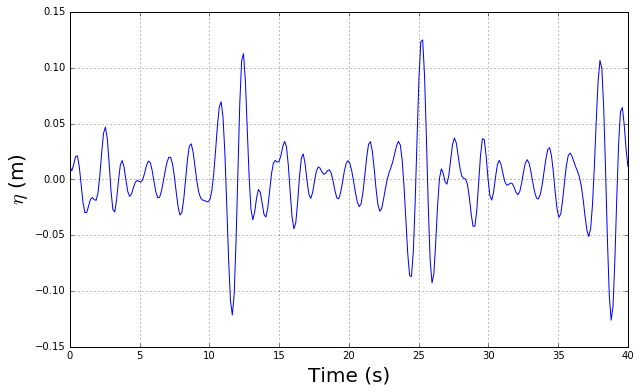

In [36]:
nperiod = 20
npoints = 15
nn = npoints * nperiod
tnlist=np.linspace(0,nperiod*Tp,nn)
eta_t = np.zeros(len(tnlist),)
psize =20

#Calculating time series
for i in range(len(tnlist)):
    x = [2., 0.5, 0.]
    t = tnlist[i]
    eta_t[i] = RW.eta(x, t)

    
#Plotting time series
plt.figure(2, figsize=(10,6), dpi=100)
plt.xlim(0., nperiod*Tp)
plt.plot(tnlist, eta_t)
plt.xlabel("Time (s)", size=psize)
plt.ylabel("$\eta$ (m)", size=psize)
plt.grid()
plt.show()

We can also plot the free-surface at the x-y plane (wave propagation plane) using a contour plot

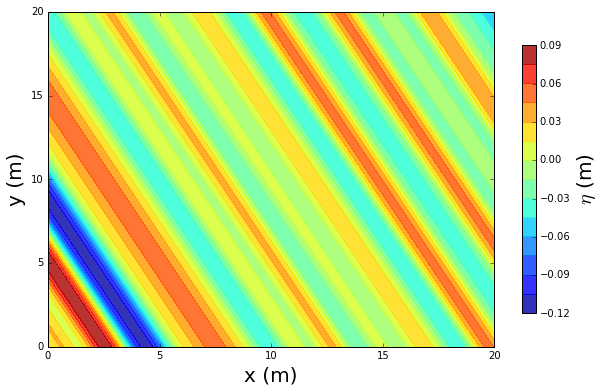

In [37]:
#Calculating the free surface elevation calculated from MWL using a 2D plane
eta_t = np.zeros((n, n),)
for i in range(len(xi)):
    for j in range(len(yi)):
        x = [xi[i], yi[j], 0]
        eta_t[i,j] = RW.eta(x, 0.)

psize = 20       
#Plotting the contour         
plt.figure(figsize=(10, 6), dpi=100)
X,Y = np.meshgrid(xi,yi)
CS = plt.contourf(X,Y,eta_t, 16, alpha=0.8, cmap='jet')
plt.xlabel("x (m)", size=psize)
plt.ylabel("y (m)", size=psize)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
CB.set_label("$\eta$ (m)", size = psize)
plt.show()

In the next cell we plot contours, showing horizontal and vertical velocity profiles at a vertical plane, aligned with the wave propagation direction 


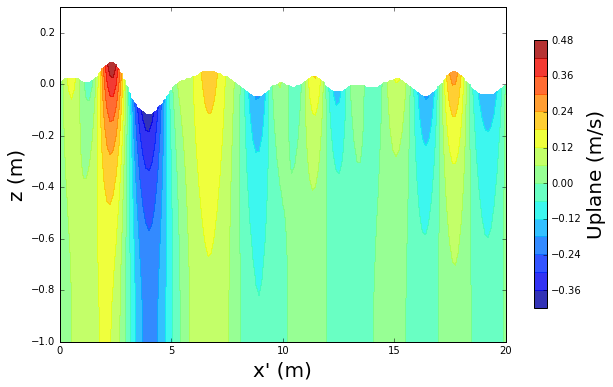

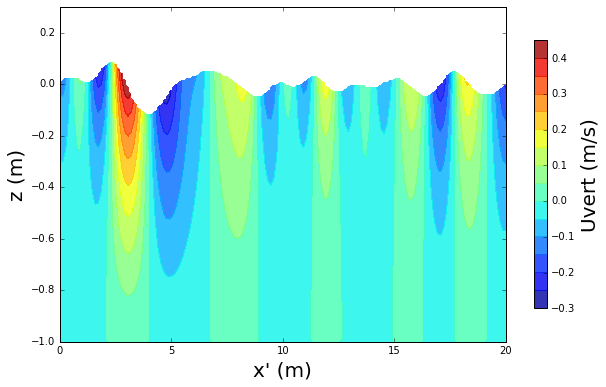

In [38]:
#Calculating velocity contours
norm = WT.setDirVector(waveDir)
normVert = WT.setVertDir(g)
ur  = np.zeros((len(xi),len(zi)),)
uv  = np.zeros((len(xi),len(zi)),)
for i in range(len(xi)):
    for ii in range(len(zi)):
        x = xi[i]*norm + [0,0,zi[ii]]
        ur[i,ii] = sum(RW.u(x, 0.)[:]*norm[:])
        uv[i,ii] = sum(RW.u(x, 0.)[:]*normVert[:])  
        if zi[ii] >  RW.eta(x,0.):
            ur[i,ii] = np.nan
            uv[i,ii] = np.nan
    
#Plotting velocity contours
plt.figure(3,figsize=(10, 6), dpi=100)
X,Y = np.meshgrid(zi,yi)
CS = plt.contourf(Y,X,ur, 16, alpha=0.8, cmap='jet')
plt.xlabel("x' (m)", size=psize)
plt.ylabel("z (m)", size=psize)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
CB.set_label("Uplane (m/s)", size = psize)
plt.show()

plt.figure(4,figsize=(10, 6), dpi=100)
X,Y = np.meshgrid(zi,yi)
CS = plt.contourf(Y,X,uv, 16, alpha=0.8, cmap='jet')
plt.xlabel("x' (m)", size=psize)
plt.ylabel("z (m)", size=psize)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
CB.set_label("Uvert (m/s)", size = psize)
plt.show()